First of all label your images and upload to roboflow.com
and genrate your dataset by using data augmentation techniques

In [ ]:
!pip install -q cython pyyaml==5.1

!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

**Installing Detectron**

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

!pip install -e detectron2_repo

In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
!curl -L "https://app.roboflow.com/ds/DhRxvtKxW4?key=hgpGbeGhHh" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0    873      0  0:00:01  0:00:01 --:--:--   873
100 11.9M  100 11.9M    0     0  8972k      0  0:00:01  0:00:01 --:--:-- 8972k
Archive:  roboflow.zip
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [12/16 06:09:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/16 06:09:57 d2.data.datasets.coco]: Loaded 429 images in COCO format from /content/train/_annotations.coco.json


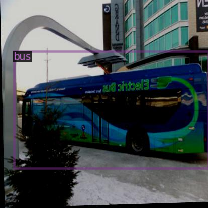

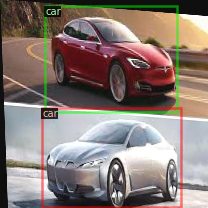

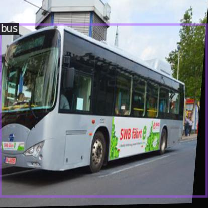

In [5]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

**Train Custom Detectron2 Detector**

The evaluation results will be stored in the coco_eval folder if no folder is provided.

Fine-tuning a Detectron2 model is nothing like writing PyTorch code. We’ll load a configuration file, change a few values, and start the training process. But hey, it really helps if you know what you’re doing 😂

For this tutorial, we’ll use the Mask R-CNN X101-FPN model. It is pre-trained on the COCO dataset and achieves very good performance. The downside is that it is slow to train.

In [6]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

Let’s load the config file and the pre-trained model weights:

In [7]:
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo

Specify the datasets (we registered those) we’ll use for training and evaluation:

In [8]:
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4

And for the optimizer, we’ll do a bit of magic to converge to something nice:

In [9]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

Except for the standard stuff (batch size, max number of iterations, and learning rate) we have a couple of interesting params:

    WARMUP_ITERS - the learning rate starts from 0 and goes to the preset one for this number of iterations
    STEPS - the checkpoints (number of iterations) at which the learning rate will be reduced by GAMMA

Finally, we’ll specify the number of classes and the period at which we’ll evaluate on the test set:

In [10]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # i have make a mistake here you do not make a mistake always set this num is  = len(no of classes) + 1, e.g if you have 2 classes you must write 3
cfg.TEST.EVAL_PERIOD = 500

Time to train, using our custom trainer:

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg)

trainer.resume_or_load(resume=False)

trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Inference with Detectron2 Saved Weights



In [14]:
%ls ./output/

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1608099114.eeaee06e4dcf.987.0  metrics.json
instances_predictions.pth                          model_final.pth


In [41]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


Now If you want to use trained model anywhere like on video and photos use these steps first cell step is for first time.Happy Codding....:)

In [55]:
with open("output/config.yaml", "w") as f:
    f.write(cfg.dump())

In [57]:
cf = get_cfg()
cf.merge_from_file("/content/output/config.yaml")
cf.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cf.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor_2 = DefaultPredictor(cf)

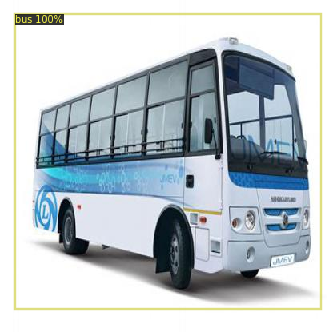

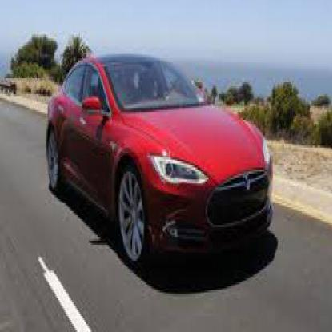

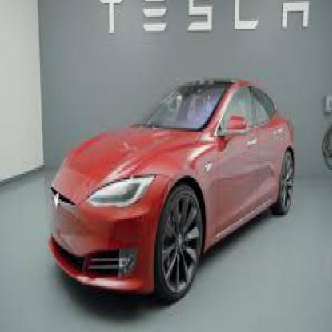

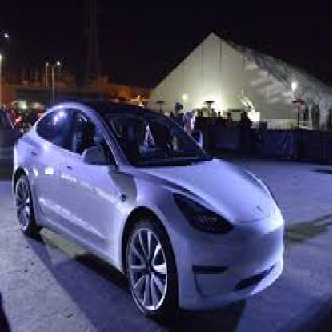

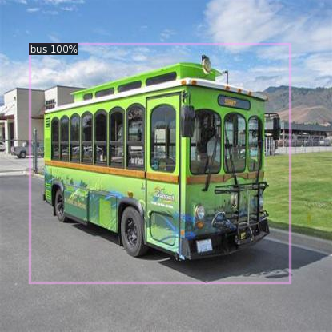

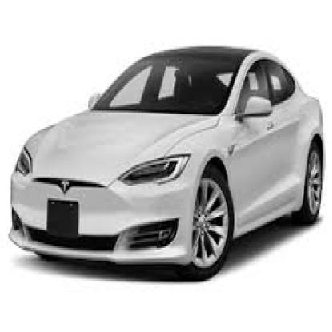

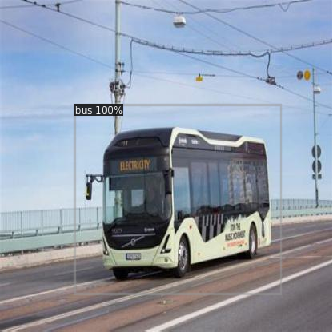

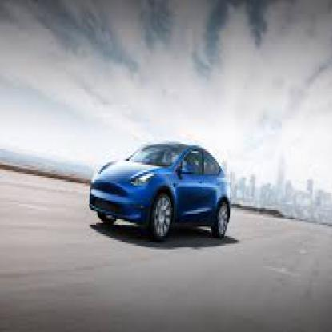

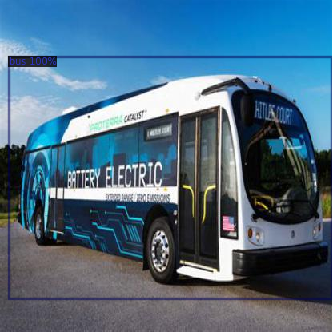

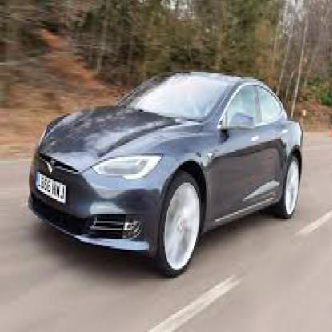

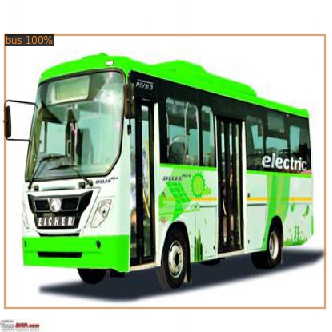

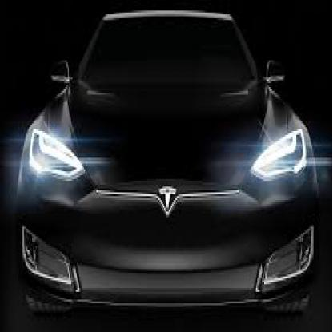

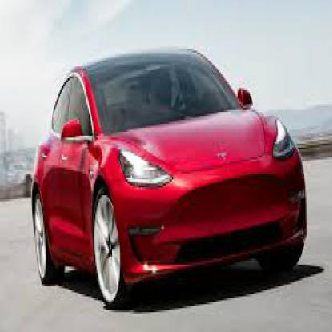

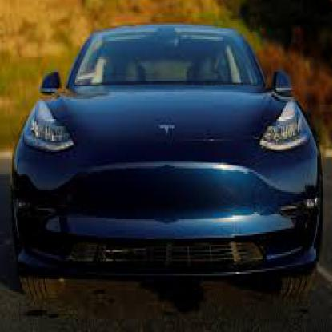

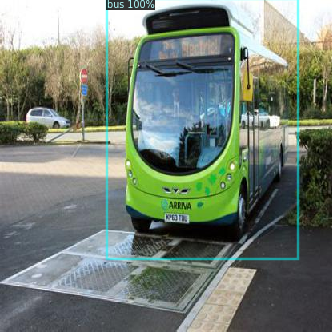

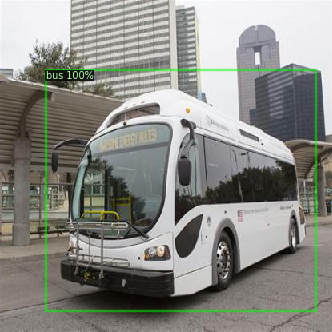

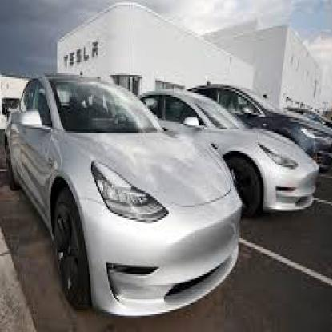

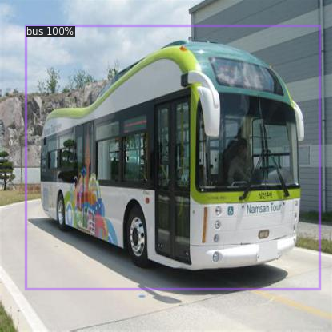

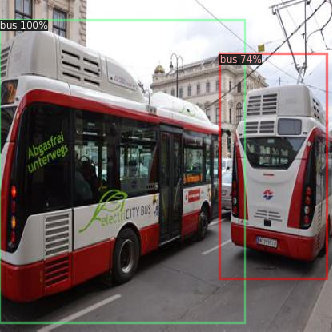

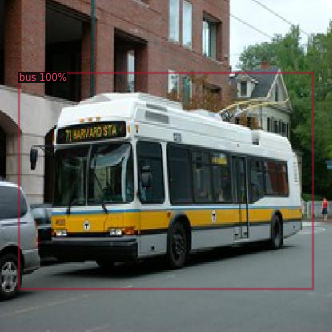

In [58]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor_2(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


I think this approch is best for object detection my tranined model cannot detect cars because i make a number classes mistakes so if you trained your model cannot make it.